In [525]:
import zipfile
import os


In [665]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import copy
import pandas as pd


plt.ion()   # interactive mode

In [738]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './flowers'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [739]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [857]:
# load test data
batch_size = 4
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
test_dir = os.path.join(data_dir,'test')
test_data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

test_dataset = datasets.ImageFolder(
    test_dir,
    test_data_transforms)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True,
    num_workers=4)

test_dataset_size =len(test_dataset)

test_names = test_dataset.classes

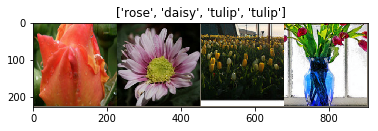

In [740]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [805]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, doc_train='doc_train.txt', doc_valid='doc_valid.txt'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    best_precision = 0.0
    best_recall = 0.0
    
    epoch_loss = 0.0
    epoch_f1 = 0.0
    epoch_precision = 0.0
    epoch_recall = 0.0
    epoch__corrects= 0.0
    
    loss_in_epoch = {'train': [], 'valid':[]}
    corrects_in_epoch = {'train': [], 'valid':[]}
    f1_in_epoch = {'train': [], 'valid':[]}
    precision_in_epoch = {'train': [], 'valid':[]}
    recall_in_epoch = {'train': [], 'valid':[]}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0
            running_f1 = []
            running_precision = []
            running_recall = []
            matrix = np.ndarray(shape=(102,102))

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                    
                # statistics
                running_f1.append(metrics.f1_score(labels.data, preds.numpy(),average='micro'))
                running_precision.append(metrics.precision_score(labels.data, preds.numpy(),average='micro'))
                running_recall.append(metrics.recall_score(labels.data, preds.numpy(),average='micro'))
                #matrix += metrics.confusion_matrix(labels.data,preds.numpy(), labels=np.arange(1,103,1) )
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_f1 = np.mean(running_f1)
            epoch_precision = np.mean(running_precision)
            epoch_recall = np.mean(running_recall)
            epoch__corrects=running_corrects / dataset_sizes[phase]
            
            loss_in_epoch[phase].append(epoch_loss)
            corrects_in_epoch[phase].append(epoch__corrects)
            f1_in_epoch[phase].append(epoch_f1)
            precision_in_epoch[phase].append(epoch_precision)
            recall_in_epoch[phase].append(epoch_recall)
            
            if phase == 'train':
                scheduler.step(epoch_loss)


            print('{} F1: {:.4f} Precision: {:.4f} Recall: {:.4f}'.format(
                phase, epoch_f1, epoch_precision, epoch_recall))
            
            
            # deep copy the model
            if phase == 'valid' and np.mean(running_f1) > best_f1:
                best_f1= np.mean(running_f1)
                best_model_wts = copy.deepcopy(model.state_dict())
        

        print()
        
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val F1: {:4f}'.format(best_f1))
    for phase in ['train', 'valid']:
        plt.figure(figsize=(20, 15))
        plt.subplot(3,2,1)
        plt.plot(np.arange(len(loss_in_epoch[phase])),loss_in_epoch[phase])
        plt.xlabel('number epoch')
        plt.ylabel('loss')

        plt.subplot(3,2,2)
        plt.plot(np.arange(len(corrects_in_epoch[phase])),corrects_in_epoch[phase])
        plt.xlabel('number epoch')
        plt.ylabel('corrects')

        plt.subplot(3,2,3)
        plt.plot(np.arange(len (f1_in_epoch[phase])), f1_in_epoch[phase])
        plt.xlabel('number epoch')
        plt.ylabel('f1')

        plt.subplot(3,2,4)
        plt.plot(np.arange(len (precision_in_epoch[phase])), precision_in_epoch[phase])
        plt.xlabel('number epoch')
        plt.ylabel('precision')

        plt.subplot(3,2,5)
        plt.plot(np.arange(len (recall_in_epoch[phase])), recall_in_epoch[phase])
        plt.xlabel('number epoch')
        plt.ylabel('recall')
        plt.show()
        
    with open(doc_valid,'w') as doc_valid:
        for i in range(len(loss_in_epoch['valid'])):
            doc_valid.write(str(i)+'  ')
            doc_valid.write(str(loss_in_epoch['valid'][i])+'  ')
            doc_valid.write(str(corrects_in_epoch['valid'][i].item())+'  ')
            doc_valid.write(str(f1_in_epoch['valid'][i])+'  ')
            doc_valid.write(str(precision_in_epoch['valid'][i])+'  ')
            doc_valid.write(str(recall_in_epoch['valid'][i])+'\n')
    with open(doc_train,'w') as doc_train:
        for i in range(len(loss_in_epoch['train'])):
            doc_train.write(str(i)+'  ')
            doc_train.write(str(loss_in_epoch['train'][i])+'  ')
            doc_train.write(str(corrects_in_epoch['train'][i].item())+'  ')
            doc_train.write(str(f1_in_epoch['train'][i])+'  ')
            doc_train.write(str(precision_in_epoch['train'][i])+'  ')
            doc_train.write(str(recall_in_epoch['train'][i])+'\n')
    
    print(loss_in_epoch[phase])
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [815]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} real: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                imshow(inputs.cpu().data[j])
                #matrix = metrics.confusion_matrix(labels.data.numpy(),preds.numpy(), labels=np.arange(1,103,1) )
                #print(np.diag(matrix))
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

In [858]:
def evaluate(model):
    model.train(False)
    
    running_f1 = []
    running_precision = []
    running_recall = []
    running_correct = 0.0
    for data in  test_loader:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if gpu_mode:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, preds = torch.max(output, 1)
        
        running_correct += int(torch.sum(preds == labels))
        running_f1.append(metrics.f1_score(labels.data, preds.numpy(),average='micro'))
        running_precision.append(metrics.precision_score(labels.data, preds.numpy(),average='micro'))
        running_recall.append(metrics.recall_score(labels.data, preds.numpy(),average='micro'))
    
    
    print('Test F1: {:.4f} Precision: {:.4f} Recall: {:.4f}'.format(
                 np.mean(running_f1), np.mean(running_precision), np.mean(running_recall)))
    
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * (running_correct) / (test_dataset_size),
       (running_correct), (test_dataset_size)))
    
    return running_correct / test_dataset_size

ResNet 18

In [816]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False


# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 512), nn.ReLU(),nn.BatchNorm1d(512), nn.Dropout(0.5),nn.Linear(512, 512), nn.ReLU(),nn.BatchNorm1d(512), nn.Dropout(0.5), nn.Linear(512, 5), nn.LogSoftmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.NLLLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.parameters(), lr=1e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


Epoch 0/6
----------
train F1: 0.5870 Precision: 0.5870 Recall: 0.5870
valid F1: 0.7971 Precision: 0.7971 Recall: 0.7971

Epoch 1/6
----------
train F1: 0.6323 Precision: 0.6323 Recall: 0.6323
valid F1: 0.8081 Precision: 0.8081 Recall: 0.8081

Epoch 2/6
----------
train F1: 0.6562 Precision: 0.6562 Recall: 0.6562
valid F1: 0.8123 Precision: 0.8123 Recall: 0.8123

Epoch 3/6
----------
train F1: 0.6529 Precision: 0.6529 Recall: 0.6529
valid F1: 0.7904 Precision: 0.7904 Recall: 0.7904

Epoch 4/6
----------
train F1: 0.6627 Precision: 0.6627 Recall: 0.6627
valid F1: 0.8081 Precision: 0.8081 Recall: 0.8081

Epoch 5/6
----------
train F1: 0.6731 Precision: 0.6731 Recall: 0.6731
valid F1: 0.8123 Precision: 0.8123 Recall: 0.8123

Epoch 6/6
----------
train F1: 0.6720 Precision: 0.6720 Recall: 0.6720
valid F1: 0.8022 Precision: 0.8022 Recall: 0.8022

Training complete in 41m 44s
Best val F1: 0.812290


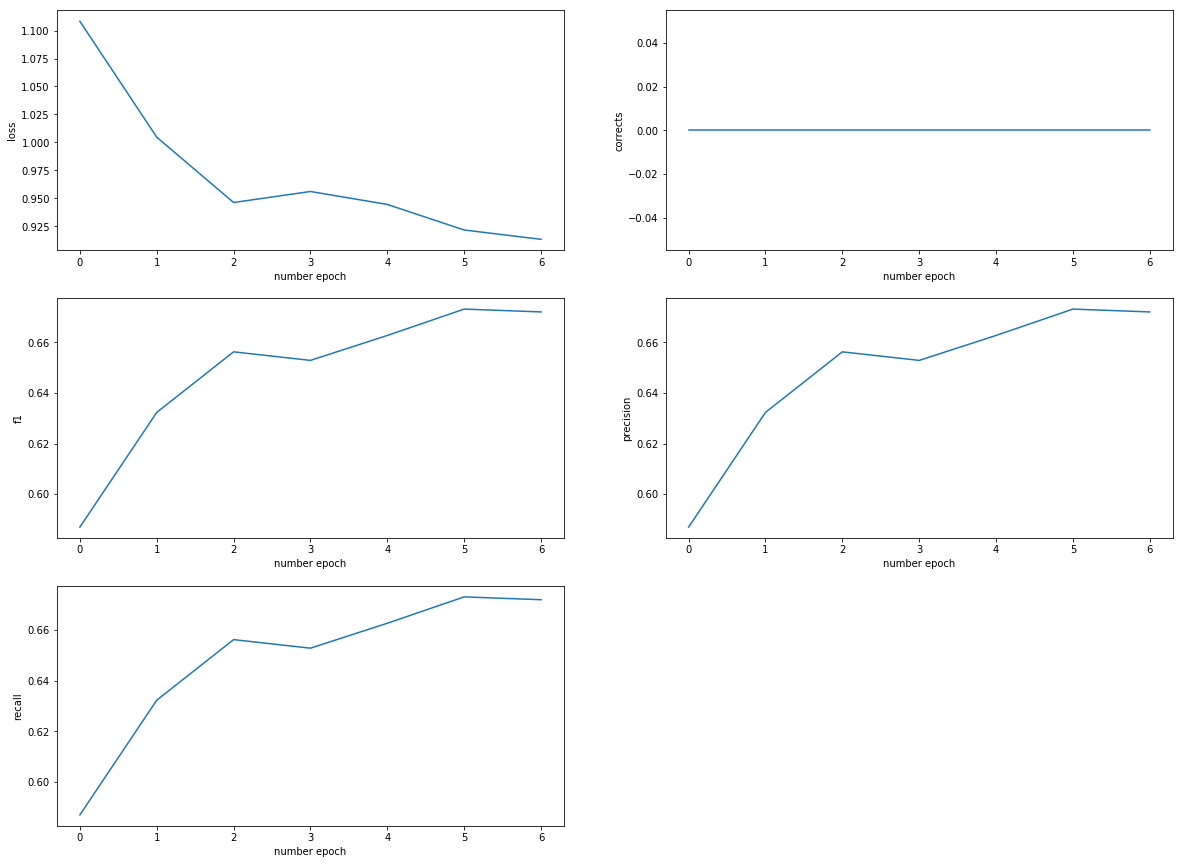

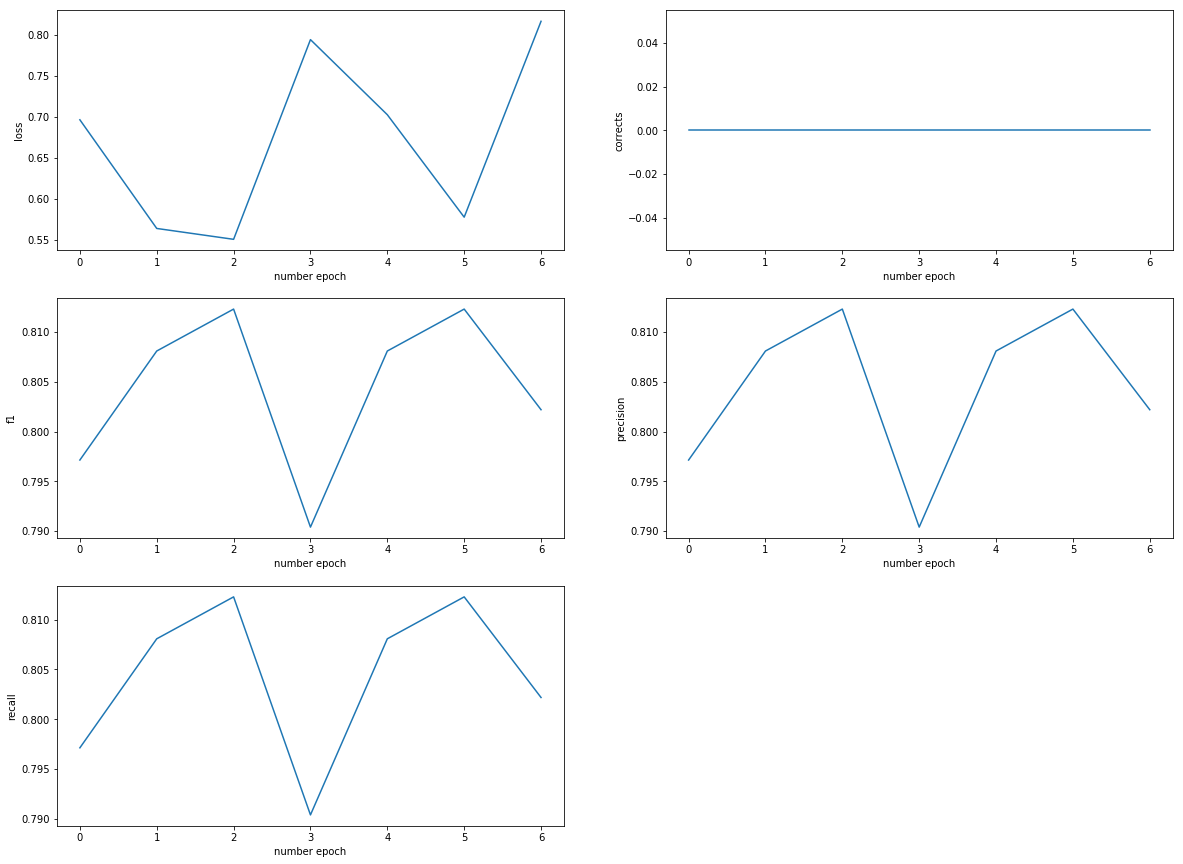

[0.6964158481812175, 0.5635306491976297, 0.5502344755432274, 0.7944680674543864, 0.7026222123186799, 0.5773290930858141, 0.8168718538329571]


In [817]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=7,doc_train='resnet18_train.txt',doc_valid='resnet18_valid.txt')

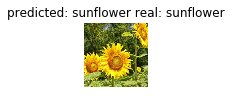

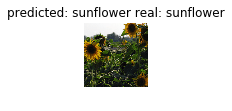

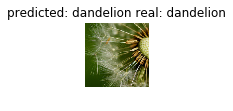

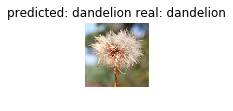

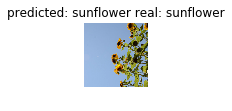

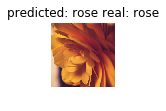

In [818]:
visualize_model(model_conv)
plt.ioff()
plt.show()

In [859]:
gpu_mode=False
acc = evaluate(model_conv)

Test F1: 0.8298 Precision: 0.8298 Recall: 0.8298

Test Accuracy (Overall): 82% (312/376)


ResNet 18 mixed

In [832]:
layers_to_unfreeze = 5
i = 0
model_mixed = torchvision.models.resnet18(pretrained=True)
for param in model_mixed.parameters():
    if i<=(18-layers_to_unfreeze):
        param.requires_grad = False
    else:
        param.requires_grad = True
    i+=1


# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_mixed.fc.in_features
model_mixed.fc = nn.Sequential(nn.Linear(num_ftrs, 512), nn.ReLU(),nn.BatchNorm1d(512), nn.Dropout(0.4), nn.Linear(512, 5), nn.LogSoftmax(dim=1))

model_mixed = model_mixed.to(device)

criterion = nn.NLLLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_mixed = optim.Adam(model_mixed.parameters(), lr=1e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_mixed, step_size=7, gamma=0.1)

Epoch 0/6
----------
train F1: 0.3604 Precision: 0.3604 Recall: 0.3604
valid F1: 0.4958 Precision: 0.4958 Recall: 0.4958

Epoch 1/6
----------
train F1: 0.4034 Precision: 0.4034 Recall: 0.4034
valid F1: 0.4150 Precision: 0.4150 Recall: 0.4150

Epoch 2/6
----------
train F1: 0.4079 Precision: 0.4079 Recall: 0.4079
valid F1: 0.4832 Precision: 0.4832 Recall: 0.4832

Epoch 3/6
----------
train F1: 0.4203 Precision: 0.4203 Recall: 0.4203
valid F1: 0.6094 Precision: 0.6094 Recall: 0.6094

Epoch 4/6
----------
train F1: 0.4203 Precision: 0.4203 Recall: 0.4203
valid F1: 0.5463 Precision: 0.5463 Recall: 0.5463

Epoch 5/6
----------
train F1: 0.3964 Precision: 0.3964 Recall: 0.3964
valid F1: 0.4554 Precision: 0.4554 Recall: 0.4554

Epoch 6/6
----------
train F1: 0.4333 Precision: 0.4333 Recall: 0.4333
valid F1: 0.5556 Precision: 0.5556 Recall: 0.5556

Training complete in 90m 30s
Best val F1: 0.609428


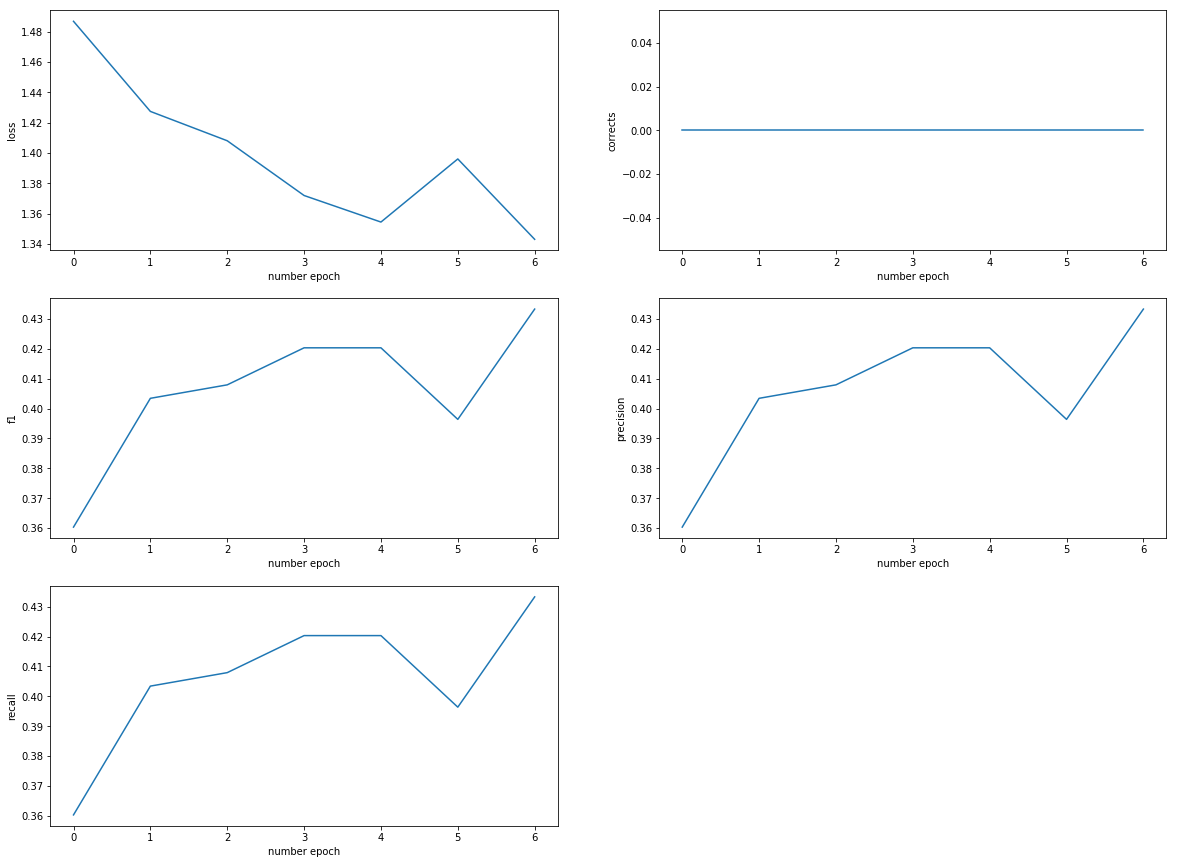

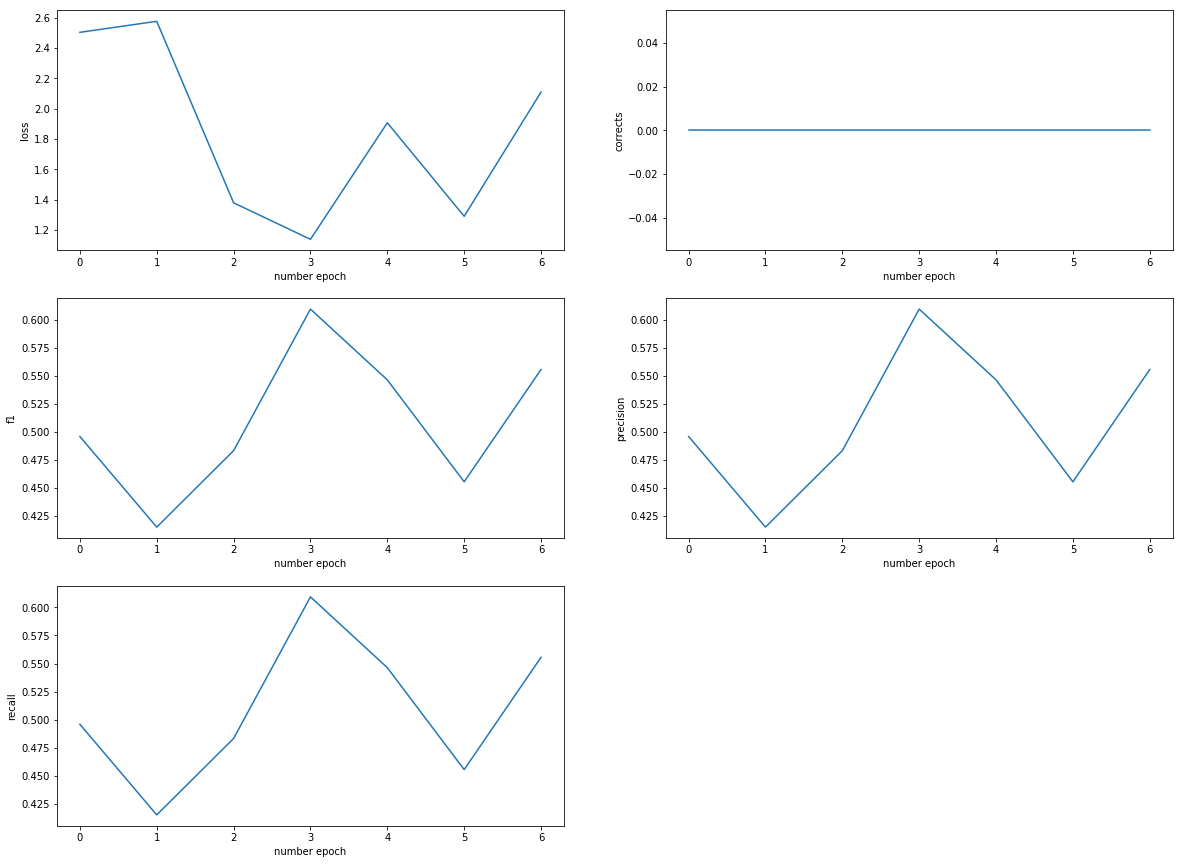

[2.503049119514755, 2.5757057887089405, 1.3799909080131145, 1.1396029656446434, 1.9073791449583029, 1.291364080996453, 2.1096483347006143]


In [833]:
model_mixed = train_model(model_mixed, criterion, optimizer_mixed,exp_lr_scheduler, num_epochs=7, doc_train='resnet18_mixed_train.txt',doc_valid='resnet18_mixed_valid.txt')

In [860]:
acc = evaluate(model_mixed)

Test F1: 0.5718 Precision: 0.5718 Recall: 0.5718

Test Accuracy (Overall): 57% (215/376)


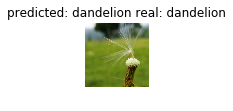

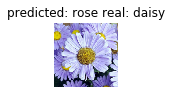

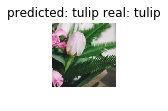

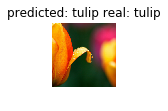

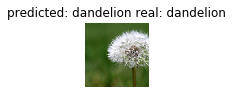

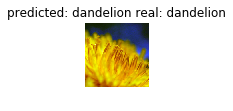

In [835]:
visualize_model(model_mixed)
plt.ioff()
plt.show()

ResNet 50

In [838]:
model_conv2 = torchvision.models.resnet50(pretrained=True)
for param in model_conv2.parameters():
    param.requires_grad = False


# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv2.fc.in_features
model_conv2.fc = nn.Sequential(nn.Linear(num_ftrs, 512), nn.ReLU(),nn.BatchNorm1d(512), nn.Dropout(0.5),nn.Linear(512, 512), nn.ReLU(),nn.BatchNorm1d(512), nn.Dropout(0.5), nn.Linear(512, 5), nn.LogSoftmax(dim=1))

model_conv2 = model_conv2.to(device)

criterion = nn.NLLLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv2 = optim.Adam(model_conv2.parameters(), lr=1e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv2, step_size=7, gamma=0.1)



Epoch 0/6
----------
train F1: 0.5985 Precision: 0.5985 Recall: 0.5985
valid F1: 0.8081 Precision: 0.8081 Recall: 0.8081

Epoch 1/6
----------
train F1: 0.6557 Precision: 0.6557 Recall: 0.6557
valid F1: 0.7854 Precision: 0.7854 Recall: 0.7854

Epoch 2/6
----------
train F1: 0.6337 Precision: 0.6337 Recall: 0.6337
valid F1: 0.8258 Precision: 0.8258 Recall: 0.8258

Epoch 3/6
----------
train F1: 0.6647 Precision: 0.6647 Recall: 0.6647
valid F1: 0.8258 Precision: 0.8258 Recall: 0.8258

Epoch 4/6
----------
train F1: 0.6639 Precision: 0.6639 Recall: 0.6639
valid F1: 0.8081 Precision: 0.8081 Recall: 0.8081

Epoch 5/6
----------
train F1: 0.6774 Precision: 0.6774 Recall: 0.6774
valid F1: 0.8274 Precision: 0.8274 Recall: 0.8274

Epoch 6/6
----------
train F1: 0.6720 Precision: 0.6720 Recall: 0.6720
valid F1: 0.8005 Precision: 0.8005 Recall: 0.8005

Training complete in 104m 29s
Best val F1: 0.827441


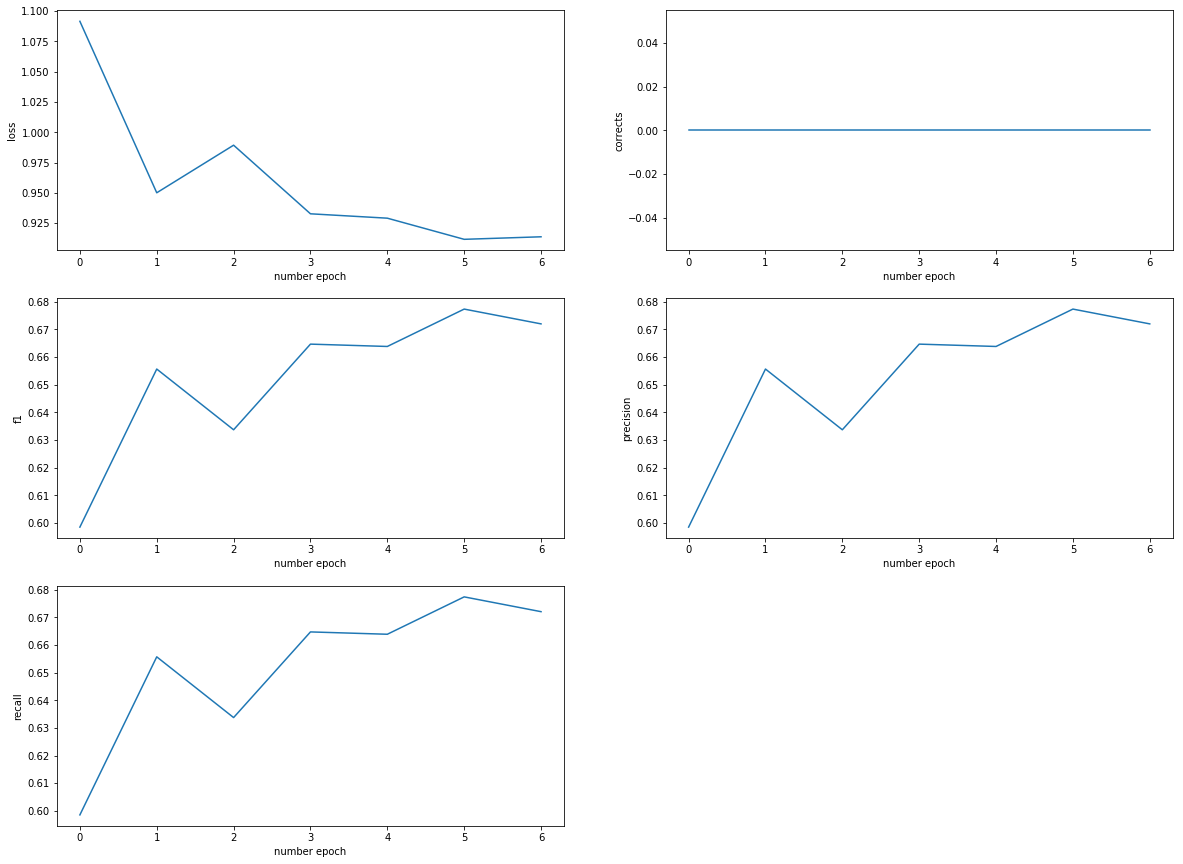

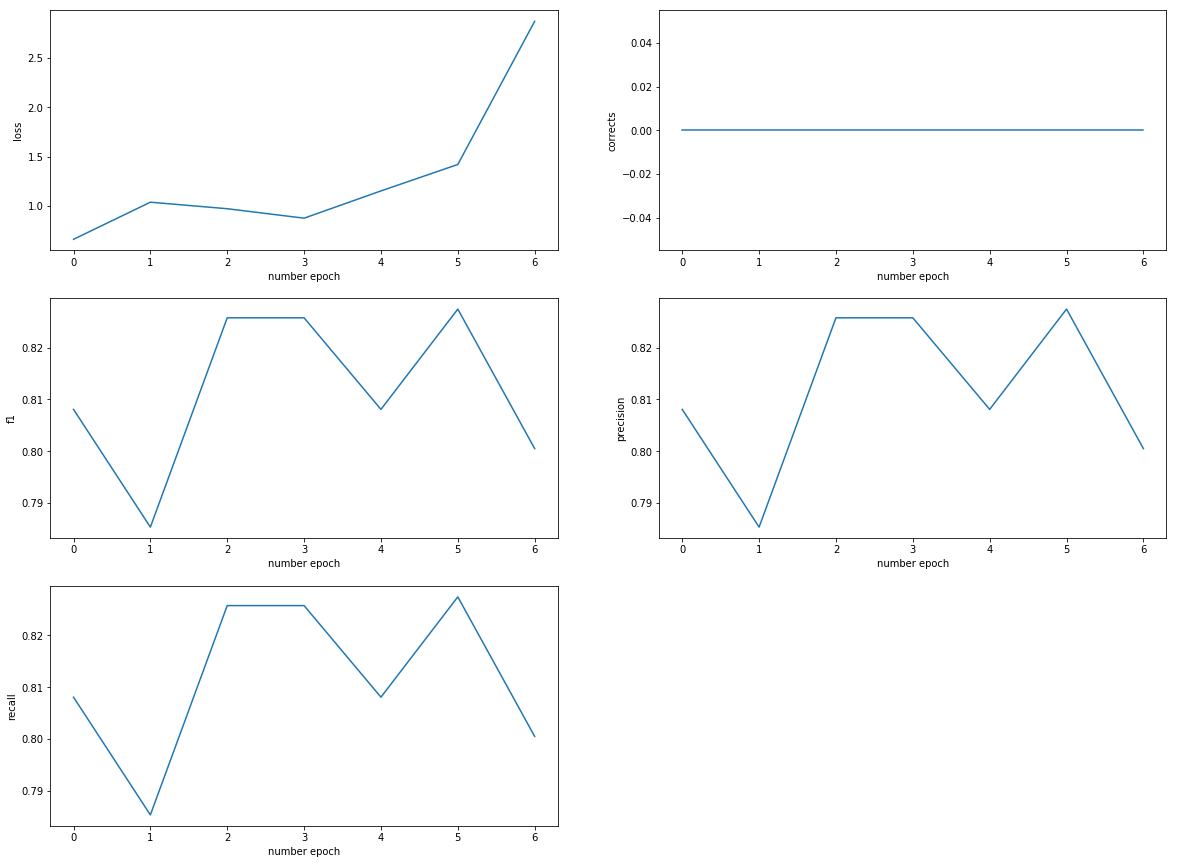

[0.6614154771347589, 1.0382454031300319, 0.9719741947666, 0.8760592644916305, 1.15271173745771, 1.4210886072320275, 2.8743436640953717]


In [839]:
model_conv2 = train_model(model_conv2, criterion, optimizer_conv2,exp_lr_scheduler, num_epochs=7,doc_train='resnet50_train.txt',doc_valid='resnet50_valid.txt')

In [861]:
acc = evaluate(model_conv2)

Test F1: 0.8644 Precision: 0.8644 Recall: 0.8644

Test Accuracy (Overall): 86% (325/376)


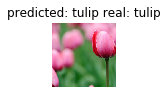

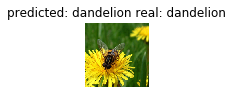

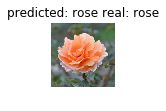

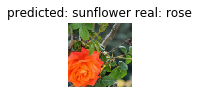

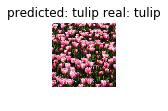

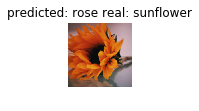

In [841]:
visualize_model(model_conv2)
plt.ioff()
plt.show()

ResNet 50 mixed

In [842]:
layers_to_unfreeze = 5
i = 0
model_mixed2 = torchvision.models.resnet50(pretrained=True)
for param in model_mixed2.parameters():
    if i<=(18-layers_to_unfreeze):
        param.requires_grad = False
    else:
        param.requires_grad = True
    i+=1


# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_mixed2.fc.in_features
model_mixed2.fc = nn.Sequential(nn.Linear(num_ftrs, 512), nn.ReLU(),nn.BatchNorm1d(512), nn.Dropout(0.4), nn.Linear(512, 5), nn.LogSoftmax(dim=1))

model_mixed2 = model_mixed2.to(device)

criterion = nn.NLLLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_mixed2 = optim.Adam(model_mixed2.parameters(), lr=1e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_mixed2, step_size=7, gamma=0.1)

Epoch 0/6
----------
train F1: 0.3288 Precision: 0.3288 Recall: 0.3288
valid F1: 0.3897 Precision: 0.3897 Recall: 0.3897

Epoch 1/6
----------
train F1: 0.3660 Precision: 0.3660 Recall: 0.3660
valid F1: 0.3645 Precision: 0.3645 Recall: 0.3645

Epoch 2/6
----------
train F1: 0.4015 Precision: 0.4015 Recall: 0.4015
valid F1: 0.4554 Precision: 0.4554 Recall: 0.4554

Epoch 3/6
----------
train F1: 0.4046 Precision: 0.4046 Recall: 0.4046
valid F1: 0.4790 Precision: 0.4790 Recall: 0.4790

Epoch 4/6
----------
train F1: 0.4096 Precision: 0.4096 Recall: 0.4096
valid F1: 0.4630 Precision: 0.4630 Recall: 0.4630

Epoch 5/6
----------
train F1: 0.4254 Precision: 0.4254 Recall: 0.4254
valid F1: 0.4537 Precision: 0.4537 Recall: 0.4537

Epoch 6/6
----------
train F1: 0.4378 Precision: 0.4378 Recall: 0.4378
valid F1: 0.5210 Precision: 0.5210 Recall: 0.5210

Training complete in 273m 18s
Best val F1: 0.521044


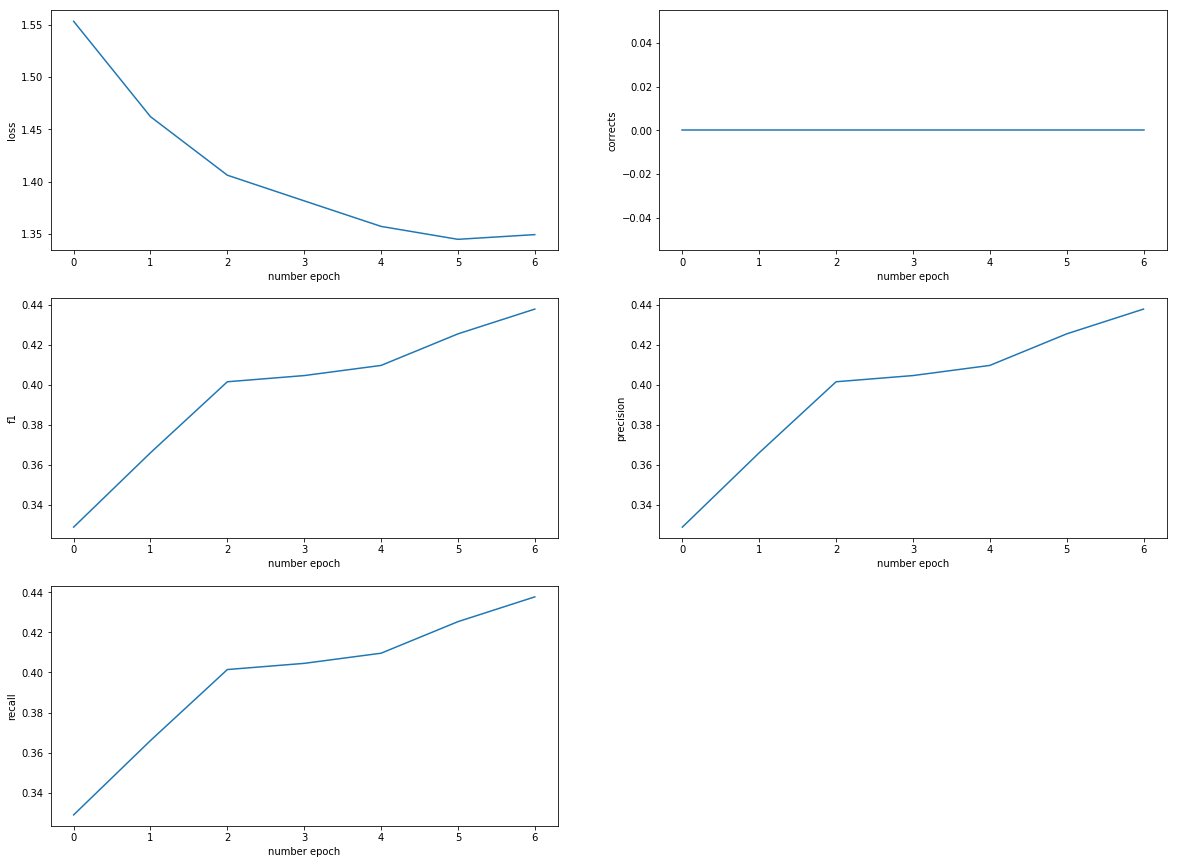

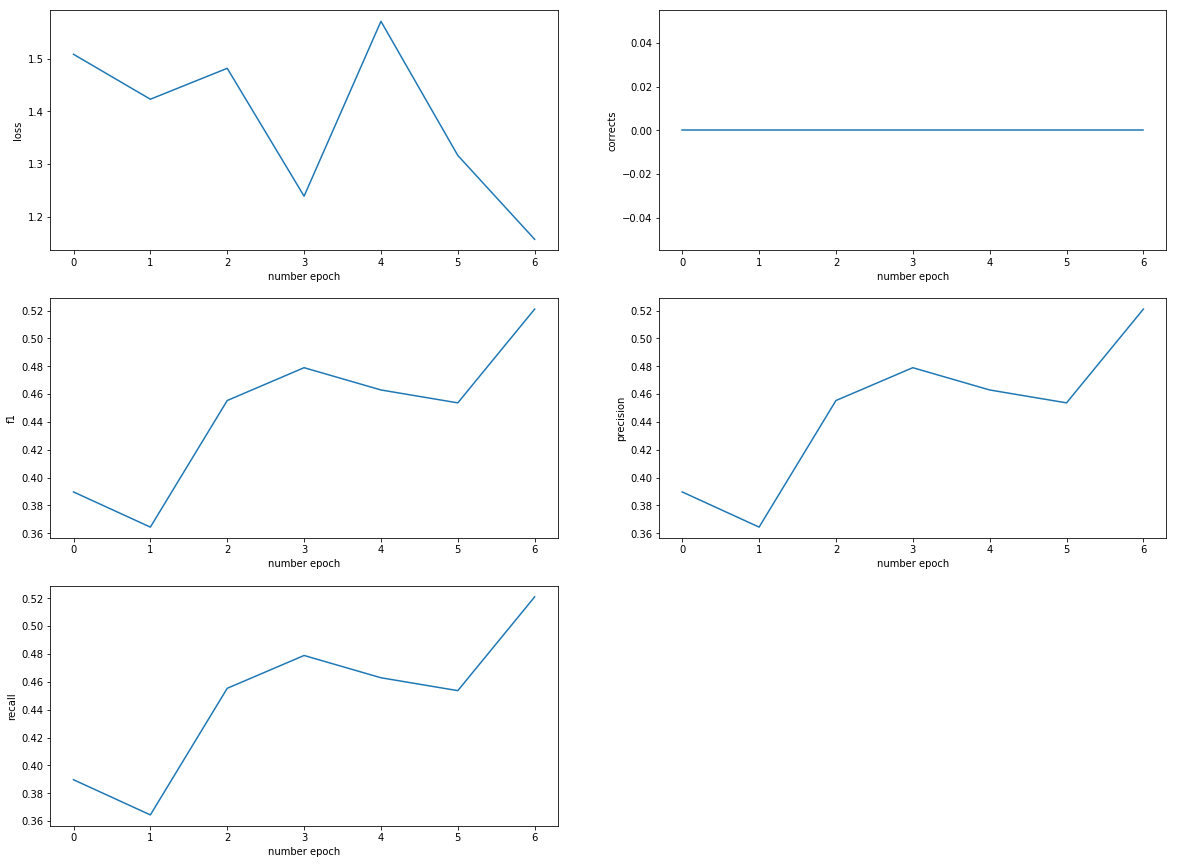

[1.508693492563465, 1.4232178971737246, 1.4820213873175125, 1.2389368832865848, 1.5713857270494291, 1.316366110572332, 1.1568810082689116]


In [843]:
model_mixed2 = train_model(model_mixed2, criterion, optimizer_mixed2,exp_lr_scheduler, num_epochs=7,doc_train='resnet50_mixed_train.txt',doc_valid='resnet50_mixed_valid.txt')

In [862]:
acc = evaluate(model_mixed2)

Test F1: 0.4255 Precision: 0.4255 Recall: 0.4255

Test Accuracy (Overall): 42% (160/376)


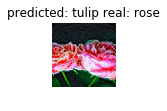

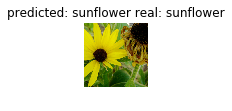

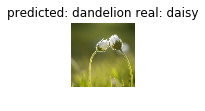

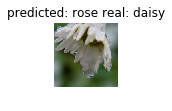

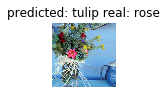

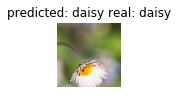

In [845]:
visualize_model(model_mixed2)
plt.ioff()
plt.show()

ResNet 152

In [847]:
model_conv3 = torchvision.models.resnet152(pretrained=True)
for param in model_conv3.parameters():
    param.requires_grad = False


# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv3.fc.in_features
model_conv3.fc = nn.Sequential(nn.Linear(num_ftrs, 512), nn.ReLU(),nn.BatchNorm1d(512), nn.Dropout(0.5),nn.Linear(512, 512), nn.ReLU(),nn.BatchNorm1d(512), nn.Dropout(0.5), nn.Linear(512, 5), nn.LogSoftmax(dim=1))

model_conv3 = model_conv3.to(device)

criterion = nn.NLLLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv3 = optim.Adam(model_conv3.parameters(), lr=1e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv3, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /Users/littlequeen/.cache/torch/checkpoints/resnet152-b121ed2d.pth


Epoch 0/6
----------
train F1: 0.6064 Precision: 0.6064 Recall: 0.6064
valid F1: 0.7668 Precision: 0.7668 Recall: 0.7668

Epoch 1/6
----------
train F1: 0.6574 Precision: 0.6574 Recall: 0.6574
valid F1: 0.8384 Precision: 0.8384 Recall: 0.8384

Epoch 2/6
----------
train F1: 0.6655 Precision: 0.6655 Recall: 0.6655
valid F1: 0.7719 Precision: 0.7719 Recall: 0.7719

Epoch 3/6
----------
train F1: 0.6723 Precision: 0.6723 Recall: 0.6723
valid F1: 0.8418 Precision: 0.8418 Recall: 0.8418

Epoch 4/6
----------
train F1: 0.6698 Precision: 0.6698 Recall: 0.6698
valid F1: 0.8628 Precision: 0.8628 Recall: 0.8628

Epoch 5/6
----------
train F1: 0.6709 Precision: 0.6709 Recall: 0.6709
valid F1: 0.7753 Precision: 0.7753 Recall: 0.7753

Epoch 6/6
----------
train F1: 0.6731 Precision: 0.6731 Recall: 0.6731
valid F1: 0.7896 Precision: 0.7896 Recall: 0.7896

Training complete in 245m 32s
Best val F1: 0.862795


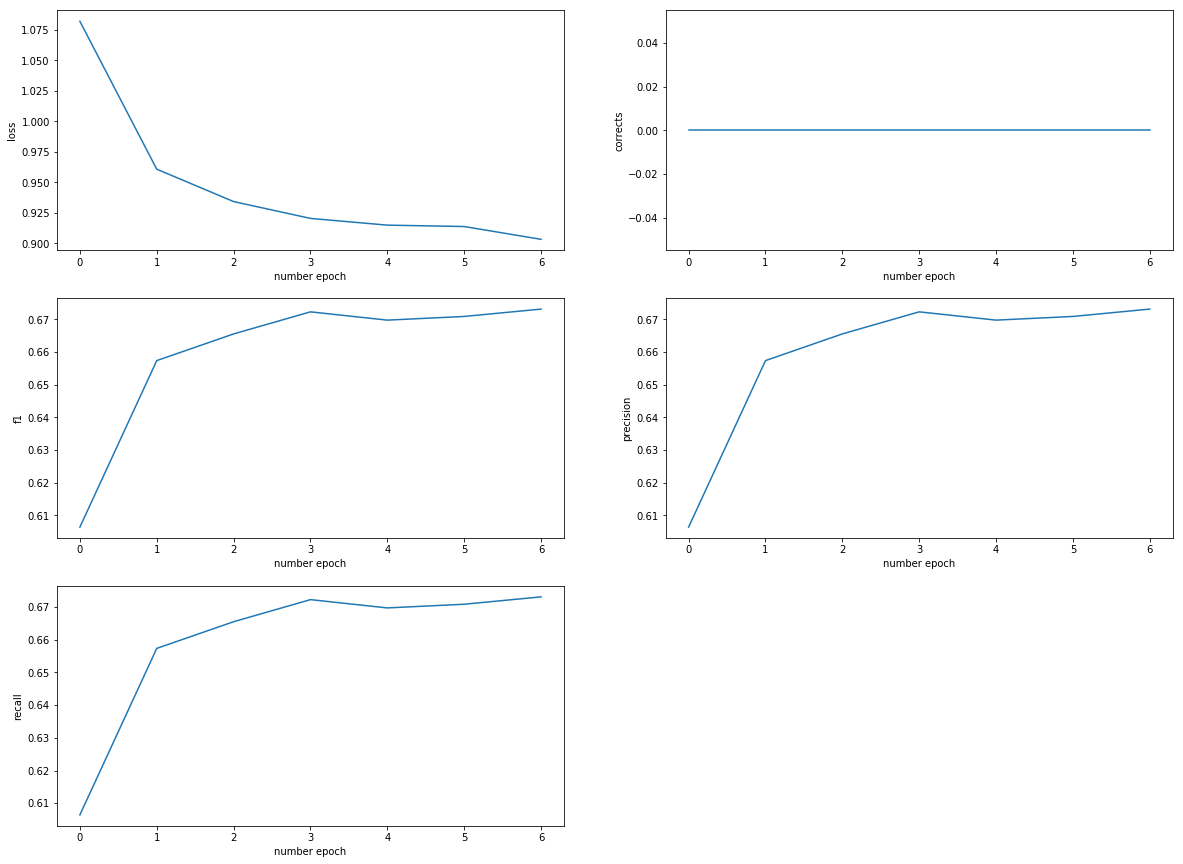

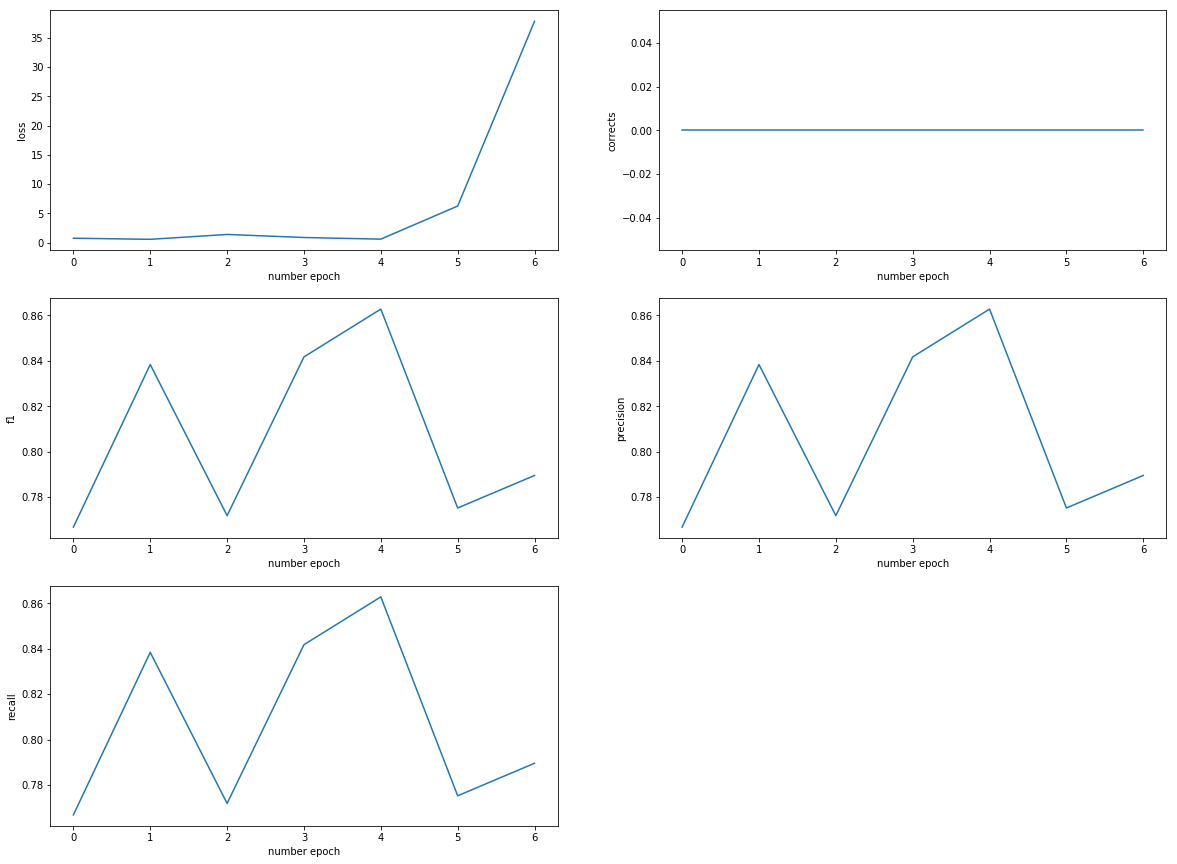

[0.7620574703322182, 0.5738206924705566, 1.4070348212613335, 0.8862057106781609, 0.6047667468650432, 6.26072479846734, 37.81862081308154]


In [848]:
model_conv3 = train_model(model_conv3, criterion, optimizer_conv3,exp_lr_scheduler, num_epochs=7,doc_train='resnet152_train.txt',doc_valid='resnet152_valid.txt')

In [863]:
acc = evaluate(model_conv3)

Test F1: 0.8803 Precision: 0.8803 Recall: 0.8803

Test Accuracy (Overall): 88% (331/376)


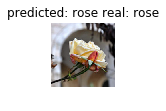

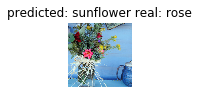

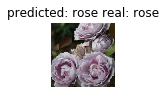

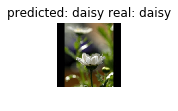

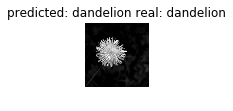

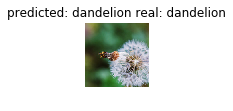

In [850]:
visualize_model(model_conv3)
plt.ioff()
plt.show()

ResNet 152 mixed

In [851]:
layers_to_unfreeze = 5
i = 0
model_mixed3 = torchvision.models.resnet152(pretrained=True)
for param in model_mixed3.parameters():
    if i<=(18-layers_to_unfreeze):
        param.requires_grad = False
    else:
        param.requires_grad = True
    i+=1


# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_mixed3.fc.in_features
model_mixed3.fc = nn.Sequential(nn.Linear(num_ftrs, 512), nn.ReLU(),nn.BatchNorm1d(512), nn.Dropout(0.4), nn.Linear(512, 5), nn.LogSoftmax(dim=1))

model_mixed3 = model_mixed3.to(device)

criterion = nn.NLLLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_mixed3 = optim.Adam(model_mixed3.parameters(), lr=1e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_mixed3, step_size=7, gamma=0.1)

Epoch 0/6
----------
train F1: 0.2827 Precision: 0.2827 Recall: 0.2827
valid F1: 0.3611 Precision: 0.3611 Recall: 0.3611

Epoch 1/6
----------
train F1: 0.3578 Precision: 0.3578 Recall: 0.3578
valid F1: 0.4621 Precision: 0.4621 Recall: 0.4621

Epoch 2/6
----------
train F1: 0.4181 Precision: 0.4181 Recall: 0.4181
valid F1: 0.3392 Precision: 0.3392 Recall: 0.3392

Epoch 3/6
----------
train F1: 0.3767 Precision: 0.3767 Recall: 0.3767
valid F1: 0.4933 Precision: 0.4933 Recall: 0.4933

Epoch 4/6
----------
train F1: 0.4155 Precision: 0.4155 Recall: 0.4155
valid F1: 0.4823 Precision: 0.4823 Recall: 0.4823

Epoch 5/6
----------
train F1: 0.4378 Precision: 0.4378 Recall: 0.4378
valid F1: 0.4529 Precision: 0.4529 Recall: 0.4529

Epoch 6/6
----------
train F1: 0.4538 Precision: 0.4538 Recall: 0.4538
valid F1: 0.4705 Precision: 0.4705 Recall: 0.4705

Training complete in 754m 10s
Best val F1: 0.493266


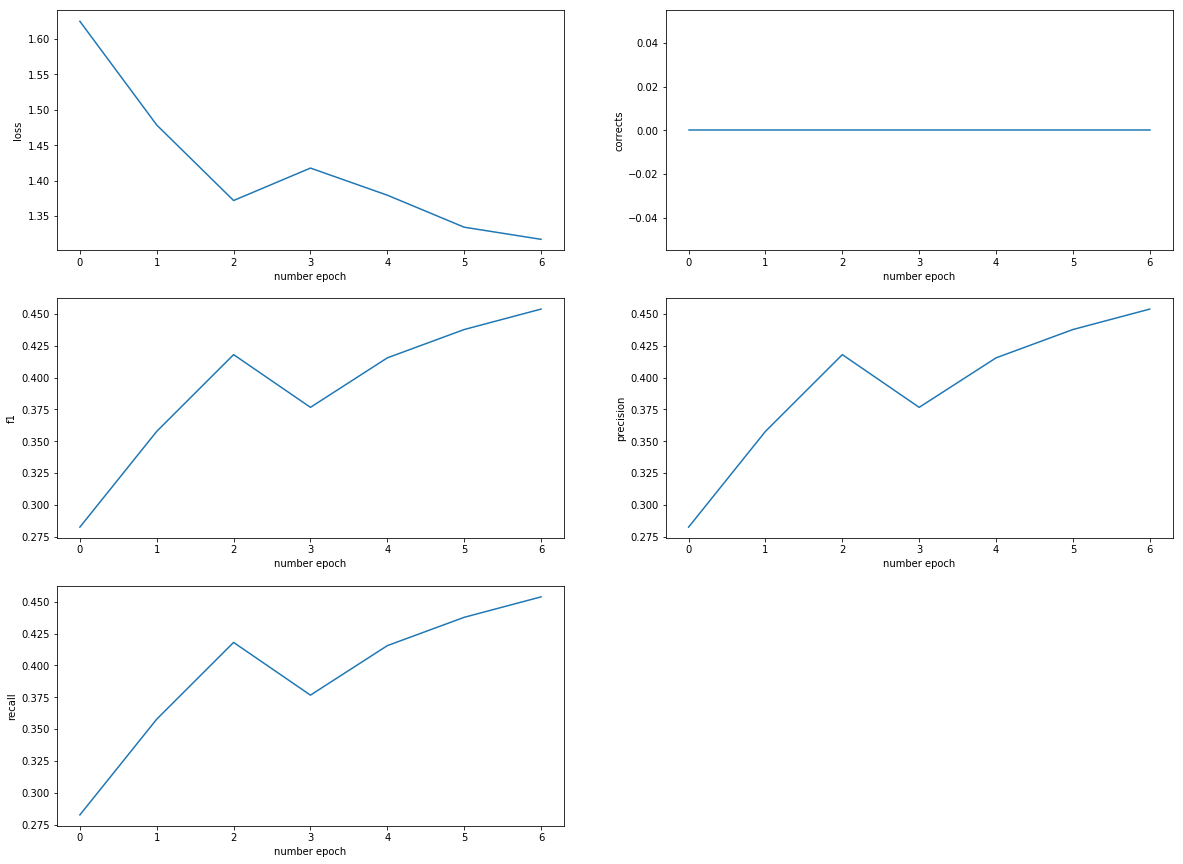

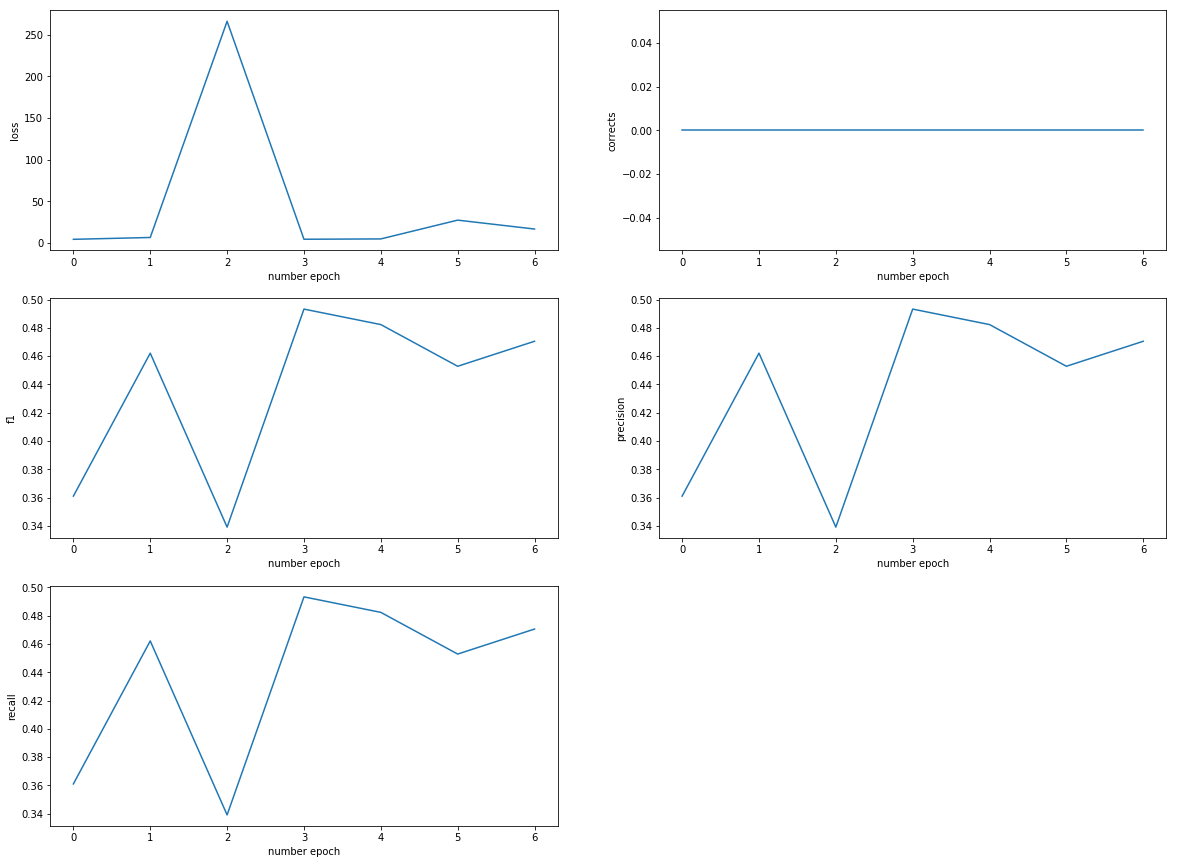

[4.261694564095026, 6.479721714424182, 266.16107794665083, 4.348759874211082, 4.742486797405195, 27.30717321739921, 16.619497292253037]


In [852]:
model_mixed3 = train_model(model_mixed3, criterion, optimizer_mixed3,exp_lr_scheduler, num_epochs=7,doc_train='resnet152_mixed_train.txt',doc_valid='resnet152_mixed_valid.txt')

In [864]:
acc = evaluate(model_mixed3)

Test F1: 0.5080 Precision: 0.5080 Recall: 0.5080

Test Accuracy (Overall): 50% (191/376)


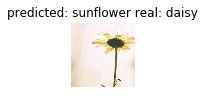

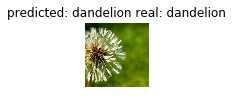

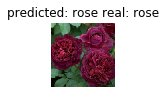

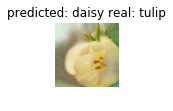

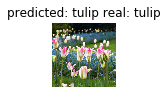

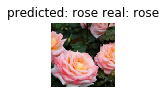

In [854]:
visualize_model(model_mixed3)
plt.ioff()
plt.show()